# Intro to DLC2Action

DLC2Action is a package for automatic behavior prediction. It offers implementation of SOTA models and keeps track of experiments.

To see how it works, we will experiment on a relatively small [publically available](https://github.com/ETHZ-INS/DLCAnalyzer/tree/master/data/OFT) dataset (Sturman, 2020). Run the code below to download the data.

Note that the results we are getting here are not optimal because we are using very small numbers of epochs and trials to make the execution time fit within a short tutorial.

NOTE: If you want to run this in google colab, we recommend to use the notebook at [this link](https://colab.research.google.com/drive/12yLnK_xh4-ci10Qn1v8vFOcAnel5SlB3?usp=sharing).


Now let's download the data. Downloading the data and installing the packages can take up to about 5-10 minutes.

In [14]:
#download the data
!curl https://transfer.sh/g8t8Vy/OFT.zip -o OFT.zip
!apt-get install unzip
!unzip OFT.zip -d OFT
!mv OFT/OFT/OFT OFT_data

Downloading...
From: https://drive.google.com/uc?id=1c-dX7MtRGPSGSrNp3Uaf3aOIzokzuj69
To: /home/liza/DLC2Action_minimal/examples/OFT.zip
100%|█████████████████████████████████████████| 327M/327M [00:02<00:00, 111MB/s]
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
Archive:  OFT.zip
   creating: OFT/OFT/
   creating: OFT/OFT/Labels/
  inflating: OFT/OFT/Labels/21_02_A_190507131119.csv  
  inflating: OFT/OFT/Labels/37_03_A_190507134213.csv  
  inflating: OFT/OFT/Labels/17_02_A_190507120259.csv  
  inflating: OFT/OFT/Labels/49_04_A_190507125609.csv  
  inflating: OFT/OFT/Labels/48_04_A_190507123817.csv  
  inflating: OFT/OFT/Labels/13_01_A_190507145949.csv  
  inflating: OFT/OFT/Labels/57_04_A_190507150030.csv  
  inflating: OFT/OFT/Labels/3_01_A_190507121945.csv  
  inflating: OFT/OFT/Labels/45_04_A_190507114741.csv  
  inflating: OFT/OFT/Labels/58_04_A_1905071

Installing `dlc2action`...

In [ ]:
!python -m pip install dlc2action

In [15]:
from dlc2action.project import Project
import os

CURRENT_PATH = os.getcwd()
DATA_PATH = os.path.join(CURRENT_PATH, "OFT_data", "Output_DLC")
LABELS_PATH = os.path.join(CURRENT_PATH, "OFT_data", "Labels")
PROJECTS_PATH = os.path.join(CURRENT_PATH, "DLC2Action")

High-level methods in DLC2Action are almost exclusively accessed through the `dlc2action.project.Project` class. A project instance should loosely correspond to a specific goal (e.g. generating automatic annotations for dataset A with input format X). You can use it to optimize hyperparameters, run experiments, analyze results and generate new data.

**Best practices**
- When you need to do something with a different data type or unrelated files, it's better to create a new project to keep the experiment history easy to understand.
- Each project is associated with a folder on your computer that contains all settings, meta files and experiment outputs. Those folders are created in the folder at `projects_path`. It's generally a good idea to choose one and stick to it throughout projects.

### Creating a project

Let's begin!

We will create a project called `"oft"`, with `"dlc_track"` input and `"csv"` annotation format. 

You can run `Project.print_data_types()` and `Project.print_annotation_types()` to find out more about other options.

In [16]:
Project.remove_project("oft", projects_path=PROJECTS_PATH)
project = Project(
    "oft",
    data_path=DATA_PATH,
    annotation_path=LABELS_PATH,
    projects_path=PROJECTS_PATH,
    data_type="dlc_track",
    annotation_type="csv",
)

Projects have a generalized `help` function.

In [17]:
project.help()

AVAILABLE HELP FUNCTIONS:
- Try running `project.help(keyword)` with the following keywords:
    - model: to get more information on available models,
    - features: to get more information on available feature extraction modes,
    - partition_method: to get more information on available train/test/val partitioning methods,
    - metrics: to see a list of available metric functions.
    - data: to see help for expected data structure
- To start working with this project, first run `project.list_blanks()` to check which parameters need to be filled in.
- After a model and metrics are set, run `project.list_basic_parameters()` to see a list of the most important parameters that you might want to modify
- If you want to dig deeper, get the full dictionary with project._read_parameters() (it is a `ruamel.yaml.comments.CommentedMap` instance).




In [18]:
Project.print_data_types()

DATA TYPES:
dlc_tracklet:

    DLC tracklet data

    Assumes the following file structure:
    ```
    data_path
    ├── video1DLC1000.pickle
    ├── video2DLC400.pickle
    ├── video1_features.pt
    └── video2_features.pt
    ```
    Here `data_suffix` is `{'DLC1000.pickle', 'DLC400.pickle'}` and `feature_suffix` (optional) is `'_features.pt'`.

    The feature files should to be dictionaries where keys are clip IDs (e.g. animal names) and values are
    feature values (arrays of shape `(#frames, #features)`). If the arrays are shaped as `(#features, #frames)`,
    set `transpose_features` to `True`.

    The files can be saved with `numpy.save()` (with `.npy` extension), `torch.save()` (with `.pt` extension) or
    with `pickle.dump()` (with `.pickle` or `.pkl` extension).
    
dlc_track:

    DLC track data

    Assumes the following file structure:
    ```
    data_path
    ├── video1DLC1000.pickle
    ├── video2DLC400.pickle
    ├── video1_features.pt
    └── video2_features.pt


Let's start by checking if our files are organized correctly.

In [19]:
project.help("data")

DATA:
Video data: dlc_track

    DLC track data

    Assumes the following file structure:
    ```
    data_path
    ├── video1DLC1000.pickle
    ├── video2DLC400.pickle
    ├── video1_features.pt
    └── video2_features.pt
    ```
    Here `data_suffix` is `{'DLC1000.pickle', 'DLC400.pickle'}` and `feature_suffix` (optional) is `'_features.pt'`.

    The feature files should to be dictionaries where keys are clip IDs (e.g. animal names) and values are
    feature values (arrays of shape `(#frames, #features)`). If the arrays are shaped as `(#features, #frames)`,
    set `transpose_features` to `True`.

    The files can be saved with `numpy.save()` (with `.npy` extension), `torch.save()` (with `.pt` extension) or
    with `pickle.dump()` (with `.pickle` or `.pkl` extension).
    
Annotation data: csv

    CSV type annotation data

    Assumes that files are saved as .csv tables with at least the following columns:
    - from / start : start of action,
    - to / end : end of action,
 

## Setting parameters

After the data structure is sorted out, it's time to configure the parameter settings. 

Every project keeps fixed settings written in configuration files in the project folder. When you want to change something, you have two options: modifying the configuration files so that this new value becomes the default (with `project.set_main_parameters` or `project.update_parameters`) or passing a `parameters_update` argument to your function so that the settings only change for this run.

We will start with setting the defaults.

As we saw in the help message, the first step is checking which essential parameters are missing with `project.list_blanks()`

In [20]:
project.list_blanks()

Before running experiments, please update all the blanks.
To do that, you can run this.
--------------------------------------------------------
project.update_parameters(
    {
        "data": {
            "data_suffix": ..., # set; the data files should have the format of {video_id}{data_suffix}, e.g. video1_suffix.pickle, where video1 is the video is and _suffix.pickle is the suffix
            "canvas_shape": ..., # list; the size of the canvas where the pose was defined
            "annotation_suffix": ..., # str | set, optional the suffix or the set of suffices such that the annotation files are named {video_id}{annotation_suffix}, e.g, video1_suffix.pickle where video1 is the video id and _suffix.pickle is the suffix
            "fps": ..., # int; fps (assuming the annotations are given in seconds, otherwise set any value)
        },
        "general": {
            "exclusive": ..., # bool; if true, single-label classification is used; otherwise multi-label
        },
    }
)


We can copy this code, fill in the information and run it.

In [21]:
project.update_parameters(
    {
        "data": {
            "data_suffix": "DeepCut_resnet50_Blockcourse1May9shuffle1_1030000.csv", # set; the data files should have the format of {video_id}{data_suffix}, e.g. video1_suffix.pickle, where video1 is the video is and _suffix.pickle is the suffix
            "canvas_shape": [928, 576], # list; the size of the canvas where the pose was defined
            "annotation_suffix": ".csv", # str | set, optional the suffix or the set of suffices such that the annotation files are named {video_id}{annotation_suffix}, e.g, video1_suffix.pickle where video1 is the video id and _suffix.pickle is the suffix
            "fps": 25 # int; fps (assuming the annotations are given in seconds, otherwise set any value)
        },
        "general": {
            "exclusive": True, # bool; if true, single-label classification is used; otherwise multi-label
        },
    }
)

Now we're all set and can start training models. However, we can take an extra step and check out what other parameters are available.

Note that this function is only showing us the parameters for the metric functions and the model that are selected as default at the moment. If you want to see what parameters there are for other models and metrics, try setting them first with `project.set_main_parameters()` or with `project.update_parameters()`.

In [22]:
project.list_basic_parameters()

BASIC PARAMETERS:
Here is a list of current parameters.
You can copy this code, change the parameters you want to set and run it to update the project config.
--------------------------------------------------------
project.update_parameters(
    {
        "general": {
            "model_name": "c2f_tcn", # str; model name (run project.help("model") for more info)
            "metric_functions": {'precision', 'recall', 'f1'}, # set; set of metric names (run project.help("metrics") for more info)
            "ignored_clips": None, # list; a list of string clip ids (agent names) to be ignored
            "len_segment": 512, # int; the length of segments (in frames) to cut the videos into
            "overlap": 0.75, # int; the overlap (in frames) between neighboring segments
            "interactive": False, # bool; if true, annotations are assigned and features are computed for pairs of clips (animals)
        },
        "data": {
            "data_suffix": "DeepCut_resnet50_Blockcourse

We can copy this into a code cell to make it easier to read.

In [23]:
project.update_parameters(
    {
        "general": {
            "model_name": "c2f_tcn", # str; model name (run project.help("model") for more info)
            "metric_functions": {'precision', 'recall', 'f1'}, # set; set of metric names (run project.help("metrics") for more info)
            "ignored_clips": None, # list; a list of string clip ids (agent names) to be ignored
            "len_segment": 512, # int; the length of segments (in frames) to cut the videos into
            "overlap": 0.75, # int; the overlap (in frames) between neighboring segments
            "interactive": False, # bool; if true, annotations are assigned and features are computed for pairs of clips (animals)
        },
        "data": {
            "data_suffix": "DeepCut_resnet50_Blockcourse1May9shuffle1_1030000.csv", # set; the data files should have the format of {video_id}{data_suffix}, e.g. video1_suffix.pickle, where video1 is the video is and _suffix.pickle is the suffix
            "feature_suffix": None, # str; the feature files should be stored in the data folder and named {video_id}{feature_suffix}
            "annotation_suffix": ".csv", # str | set, optional the suffix or the set of suffices such that the annotation files are named {video_id}{annotation_suffix}, e.g, video1_suffix.pickle where video1 is the video id and _suffix.pickle is the suffix
            "canvas_shape": [928, 576], # list; the size of the canvas where the pose was defined
            "ignored_bodyparts": None, # set; the set of string names of bodyparts to ignore
            "likelihood_threshold": 0, # float; coordinates with lower likelihood values will be ignored
            "behaviors": None, # set; the behaviors to predict (if null, if will be inferred from the data; !!PLEASE SET IT MANUALLY if different files can have different behavior sets!!)
            "filter_annotated": True, # bool; discard long unannotated intervals during training
            "filter_background": True, # bool; only label frames as background if a behavior is annotated somewhere close
            "visibility_min_score": 0, # float; the minimum visibility score for visibility filtering
            "visibility_min_frac": 0, # float; the minimum fraction of visible frames for visibility filtering
        },
        "training": {
            "lr": 0.001, # float; learning rate
            "device": "auto", # str; device
            "num_epochs": 50, # int; number of epochs
            "to_ram": False, # bool; transfer the dataset to RAM for training (preferred if the dataset fits in working memory)
            "batch_size": 64, # int; batch size
            "normalize": True, # bool; if true, normalization statistics will be computed on the training set and applied to all data
            "temporal_subsampling_size": 0.85, # float; this fraction of frames in each segment is randomly sampled at training time
            "parallel": False, # bool; if true, the model will be trained on all gpus visible in the system (use os.environ[“CUDA_VISIBLE_DEVICES”] =“{indices}” to exclude gpus in this mode)
            "val_frac": 0.2, # float; fraction of dataset to use as validation
            "test_frac": 0, # float; fraction of dataset to use as test
            "partition_method": "random", # str; the train/test/val partitioning method (for more info run project.help("partition_method"))
        },
        "losses": {
            "ms_tcn": {
                "focal": True, # bool; if True, focal loss will be used
                "gamma": 2, # float; the gamma parameter of focal loss
                "alpha": 0.001, # float; the weight of consistency loss
            },
        },
        "metrics": {
            "f1": {
                "average": "macro", # ['macro', 'micro', 'none']; averaging method for classes
                "ignored_classes": None, # set; a set of class ids to ignore in calculation
                "threshold_value": 0.5, # float; the probability threshold for positive samples
            },
            "recall": {
                "average": "macro", # ['macro', 'micro', 'none']; averaging method for classes
                "ignored_classes": None, # set; a set of class ids to ignore in calculation
                "threshold_value": 0.5, # float; the probability threshold for positive samples
            },
            "precision": {
                "average": "macro", # ['macro', 'micro', 'none']; averaging method for classes
                "ignored_classes": None, # set; a set of class ids to ignore in calculation
                "threshold_value": 0.5, # float; the probability threshold for positive samples
            },
        },
        "model": {
            "num_f_maps": 128, # int; number of maps
            "feature_dim": None, # int; if not null, intermediate features are generated with this dimension and then passed to a 2-layer MLP for classification (useful for SSL)
        },
        "features": {
            "keys": None, # set; a list of names of the features to extract (a subset of available keys; run project.help("features") for more info)
            "averaging_window": 1, # int; if >1, features are averaged with a moving window of this size (in frames)
            "distance_pairs": None, # list; a list of bodypart name tuples (e.g. `[("tail", "nose")]`) to compute distances for when `"intra_distance"` is in `keys` (by default all distances are computed)
            "angle_pairs": None, # list; a list of bodypart name tuples (e.g. `[("ear1", "nose", "ear2")]`) for the angle between `"ear1"--"nose"` and `"nose"--"ear2"` lines) to compute angle cosines for when `"angles"` is in `keys` (by default no angles are computed)
            "zone_vertices": None, # dict; a dictionary of bodypart name tuples of any length >= 3 that define zones for `"zone_bools"`and `"zone_distances"` features; keys should be zone names and values should be tuples that define the polygons (e.g. `{"main_area": ("x_min", "x_max", "y_max", "y_min"))}`)
            "zone_bools": None, # list; a list of zone and bodypart name tuples to compute binary identifiers for (1 if an animal is within the polygon or 0 if it's outside) (e.g. `[("main_area", "nose")]`); the zones should be defined in the `zone_vertices` parameter; this is only computed if `"zone_bools"` is in `keys`
            "zone_distances": None, # list; a list of zone and bodypart name tuples to compute distances for (distance from the bodypart to the closest of the boundaries) (e.g. `[("main_area", "nose")]`); the zones should be defined in the `zone_vertices` parameter; this is only computed if `"zone_distances"` is in `keys`
            "area_vertices": None, # list; a list of bodypart name tuples of any length >= 3 (e.g. `[("ear1", "nose", "ear2", "spine1")]`) that define polygons to compute areas for when `"areas"` is in `keys` (by default no areas are computed)
        },
        "augmentations": {
            "augmentations": {'add_noise'}, # set; a set of augmentations that can be applied to your data without losing information (choose any number from 'rotate', 'real_lens', 'add_noise', 'shift', 'zoom', 'mirror', 'switch', e.g. {'add_noise'. 'mirror'})
            "rotation_limits": [-1.57, 1.57], # list; list of rotation angle limits in radians ([low, high])
            "mirror_dim": {0}, # set; set of dimensions that can be mirrored (0 for x, 1 for y, 2 for z)
            "noise_std": 0.003, # float; standard deviation of noise
            "zoom_limits": [0.5, 1.5], # list; list of float zoom limits ([low, high])
            "masking_probability": 0.1, # float; the probability of masking a joint
        },
    },
)

Let's see what the options are for metrics and models.

In [24]:
project.help("model")
project.help("metrics")

MODELS:
asformer:

    An implementation of ASFormer
    
mlp:

    A Multi-Layer Perceptron
    
c2f_tcn:

    An implementation of C2F-TCN

    Requires the `"general/len_segment"` parameter to be at least 512
    
edtcn:

    An implementation of EDTCN (Endoder-Decoder TCN)
    
transformer:

    A modification of Transformer-Encoder with additional max-pooling and upsampling

    Set `num_pool` to 0 to get a standart transformer-encoder.
    


METRICS:
accuracy:

    Accuracy
    
precision:

    Precision
    
f1:

    F1 score
    
recall:

    Recall
    
count:

    Fraction of samples labeled by the model as a class
    
segmental_precision:

    Segmental precision (not advised for training)
    
segmental_recall:

    Segmental recall (not advised for training)
    
segmental_f1:

    Segmental F1 score (not advised for training)
    
edit_distance:

    Edit distance (not advised for training)

    Normalized by the length of the sequences
    
f_beta:

    F-beta score
  

Which models and metrics do you want to try out?

You can choose any metrics but the code will run much faster if you avoid those marked "not advisable for training". We can compute those later with a trained model.

In [25]:
MODEL_NAME1 = "c2f_tcn"
MODEL_NAME2 = "transformer"
METRICS = ["f1", "precision"]

We will configure the metrics in the default parameters, as well as a smaller number of epochs. The model will be updated in each experiment independently, since we want to try out more than one. We will also set the classes that we want to ignore here.

In [26]:
project.update_parameters(
    {
        "general": {"metric_functions": METRICS},
        "training": {"num_epochs": 10},
        "data": {"ignored_classes": ["StartEnd", "_DEFAULT"]}
    }
)

All done! Now we're ready to run experiments. 

## Hyperparameter search

There are many hyperparameters in model training, like the number of layers in a model or loss coefficients. The default settings for those parameters should generate reasonable results on most datasets but in order to get the most out of our data we can run a hyperparameter search.

Searches in `DLC2Action` use the `optuna` auto-ML package to sample the hyperpameter space efficiently and save time on trials that go badly from the beginning. 

There are two methods for running a search: `project.run_hyperparameter_search()` and `project.run_default_hyperparameter_search()`. As you might have guessed from the names, the second method will just load the default set of parameters for a given model while the first allows you to optimize whatever you want. For the vast majority of cases `project.run_default_hyperparameter_search()` should be enough, so that is what we will use in thi tutorial.

In [27]:
for model in [MODEL_NAME1, MODEL_NAME2]:
    project.run_default_hyperparameter_search(
        f"{model}_search",
        model_name=model,
        metric=METRICS[0],
        num_epochs=3,
        n_trials=10,
        prune=True,
    )


SEARCH c2f_tcn_search


[I 2022-11-17 03:44:03,349] A new study created in memory with name: no-name-137c4615-da68-450a-9c1b-3fe3b1870c30


Computing input features...


100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


Computing annotation arrays...


100%|██████████| 20/20 [00:00<00:00, 353.03it/s]


Number of samples:
    validation:
      {-100: 41830, 0: 61, 3: 10634, 4: 6830, 1: 1898, 2: 187}
    training:
      {-100: 173985, 3: 41141, 2: 676, 4: 23215, 1: 6620, 0: 123}
    test:
      {1: 0, 2: 0, 3: 0, 4: 0, 0: 0}
Computing normalization statistics...


100%|██████████| 240/240 [00:00<00:00, 444.94it/s]


Initializing class weights:
    1.951, 0.036, 0.355, 0.006, 0.01
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported


/home/liza/DLC2Action_minimal/dlc2action/model/c2f_tcn.py:92: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x1 = F.pad(x1, [diff // 2, diff - diff // 2])


[epoch 1]: loss 0.0201, f1 0.277
validation: loss 0.0197, f1 0.203
[epoch 2]: loss 0.0120, f1 0.388
validation: loss 0.0189, f1 0.253
[epoch 3]: loss 0.0098, f1 0.465
validation: loss 0.0180, f1 0.284
[epoch 4]: loss 0.0093, f1 0.502
validation: loss 0.0175, f1 0.409


[I 2022-11-17 03:44:25,428] Trial 0 finished with value: 0.3833069105943044 and parameters: {'losses/ms_tcn/alpha': 2.98489296397999e-05, 'losses/ms_tcn/focal': True, 'training/temporal_subsampling_size': 0.955123472289908, 'model/num_f_maps': 56, 'general/len_segment': 1024}. Best is trial 0 with value: 0.3833069105943044.


[epoch 5]: loss 0.0085, f1 0.513
validation: loss 0.0171, f1 0.457
Number of samples:
    validation:
      {-100: 41830, 0: 61, 3: 10634, 4: 6830, 1: 1898, 2: 187}
    training:
      {-100: 173985, 3: 41141, 2: 676, 4: 23215, 1: 6620, 0: 123}
    test:
      {1: 0, 2: 0, 3: 0, 4: 0, 0: 0}
Computing normalization statistics...


100%|██████████| 240/240 [00:00<00:00, 435.91it/s]


Initializing class weights:
    1.951, 0.036, 0.355, 0.006, 0.01
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported


/home/liza/DLC2Action_minimal/dlc2action/model/c2f_tcn.py:92: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x1 = F.pad(x1, [diff // 2, diff - diff // 2])


[epoch 1]: loss 0.0205, f1 0.153
validation: loss 0.0188, f1 0.122
[epoch 2]: loss 0.0118, f1 0.349
validation: loss 0.0186, f1 0.107
[epoch 3]: loss 0.0103, f1 0.434
validation: loss 0.0188, f1 0.184
[epoch 4]: loss 0.0092, f1 0.454
validation: loss 0.0191, f1 0.271


[I 2022-11-17 03:44:34,874] Trial 1 finished with value: 0.25506476561228436 and parameters: {'losses/ms_tcn/alpha': 0.0002917902826144083, 'losses/ms_tcn/focal': True, 'training/temporal_subsampling_size': 0.8481535855532814, 'model/num_f_maps': 86, 'general/len_segment': 1024}. Best is trial 0 with value: 0.3833069105943044.


[epoch 5]: loss 0.0072, f1 0.504
validation: loss 0.0183, f1 0.310
Initializing class weights:
    1.951, 0.036, 0.355, 0.006, 0.01
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported


/home/liza/DLC2Action_minimal/dlc2action/model/c2f_tcn.py:92: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x1 = F.pad(x1, [diff // 2, diff - diff // 2])


[epoch 1]: loss 0.0193, f1 0.197
validation: loss 0.0196, f1 0.210
[epoch 2]: loss 0.0126, f1 0.340
validation: loss 0.0180, f1 0.332
[epoch 3]: loss 0.0103, f1 0.432
validation: loss 0.0166, f1 0.372
[epoch 4]: loss 0.0092, f1 0.490
validation: loss 0.0157, f1 0.363


[I 2022-11-17 03:44:43,828] Trial 2 finished with value: 0.3801057239373525 and parameters: {'losses/ms_tcn/alpha': 0.001657612863156049, 'losses/ms_tcn/focal': True, 'training/temporal_subsampling_size': 0.9951538734776548, 'model/num_f_maps': 47, 'general/len_segment': 1024}. Best is trial 0 with value: 0.3833069105943044.


[epoch 5]: loss 0.0084, f1 0.522
validation: loss 0.0148, f1 0.405
Initializing class weights:
    1.951, 0.036, 0.355, 0.006, 0.01
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported


/home/liza/DLC2Action_minimal/dlc2action/model/c2f_tcn.py:92: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x1 = F.pad(x1, [diff // 2, diff - diff // 2])


[epoch 1]: loss 0.0182, f1 0.142
validation: loss 0.0194, f1 0.112
[epoch 2]: loss 0.0125, f1 0.279
validation: loss 0.0180, f1 0.114
[epoch 3]: loss 0.0110, f1 0.423
validation: loss 0.0166, f1 0.215
[epoch 4]: loss 0.0098, f1 0.492
validation: loss 0.0158, f1 0.359


[I 2022-11-17 03:44:52,410] Trial 3 finished with value: 0.3293474813302358 and parameters: {'losses/ms_tcn/alpha': 0.0006867522159376327, 'losses/ms_tcn/focal': True, 'training/temporal_subsampling_size': 0.9555397550467649, 'model/num_f_maps': 52, 'general/len_segment': 1024}. Best is trial 0 with value: 0.3833069105943044.


[epoch 5]: loss 0.0086, f1 0.517
validation: loss 0.0146, f1 0.413
Computing input features...


100%|██████████| 20/20 [00:11<00:00,  1.77it/s]


Computing annotation arrays...


100%|██████████| 20/20 [00:00<00:00, 559.83it/s]


Filtering 2.83% of samples
Number of samples:
    validation:
      {-100: 40806, 0: 61, 3: 10634, 4: 6830, 1: 1898, 2: 187}
    training:
      {-100: 166305, 3: 41141, 2: 676, 4: 23215, 1: 6620, 0: 123}
    test:
      {1: 0, 2: 0, 3: 0, 4: 0, 0: 0}
Computing normalization statistics...


100%|██████████| 465/465 [00:00<00:00, 619.03it/s]


Initializing class weights:
    3.78, 0.07, 0.688, 0.011, 0.02
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported


/home/liza/DLC2Action_minimal/dlc2action/model/c2f_tcn.py:92: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x1 = F.pad(x1, [diff // 2, diff - diff // 2])


[epoch 1]: loss 1.5417, f1 0.140
validation: loss 1.5535, f1 0.284
[epoch 2]: loss 1.2695, f1 0.259
validation: loss 1.3867, f1 0.278
[epoch 3]: loss 1.1873, f1 0.368
validation: loss 1.3114, f1 0.317
[epoch 4]: loss 1.0234, f1 0.445
validation: loss 1.2868, f1 0.475


[I 2022-11-17 03:45:15,395] Trial 4 finished with value: 0.4284265438715617 and parameters: {'losses/ms_tcn/alpha': 2.8229932017616804e-05, 'losses/ms_tcn/focal': False, 'training/temporal_subsampling_size': 0.9211721571058966, 'model/num_f_maps': 32, 'general/len_segment': 512}. Best is trial 4 with value: 0.4284265438715617.


[epoch 5]: loss 0.9739, f1 0.533
validation: loss 1.2598, f1 0.493
Number of samples:
    validation:
      {-100: 40806, 0: 61, 3: 10634, 4: 6830, 1: 1898, 2: 187}
    training:
      {-100: 166305, 3: 41141, 2: 676, 4: 23215, 1: 6620, 0: 123}
    test:
      {1: 0, 2: 0, 3: 0, 4: 0, 0: 0}
Computing normalization statistics...


100%|██████████| 465/465 [00:00<00:00, 646.53it/s]


Initializing class weights:
    3.78, 0.07, 0.688, 0.011, 0.02
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported


/home/liza/DLC2Action_minimal/dlc2action/model/c2f_tcn.py:92: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x1 = F.pad(x1, [diff // 2, diff - diff // 2])
[I 2022-11-17 03:45:19,406] Trial 5 pruned. 


Number of samples:
    validation:
      {-100: 41830, 0: 61, 3: 10634, 4: 6830, 1: 1898, 2: 187}
    training:
      {-100: 173985, 3: 41141, 2: 676, 4: 23215, 1: 6620, 0: 123}
    test:
      {1: 0, 2: 0, 3: 0, 4: 0, 0: 0}
Computing normalization statistics...


100%|██████████| 240/240 [00:00<00:00, 485.12it/s]


Initializing class weights:
    1.951, 0.036, 0.355, 0.006, 0.01
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported


/home/liza/DLC2Action_minimal/dlc2action/model/c2f_tcn.py:92: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x1 = F.pad(x1, [diff // 2, diff - diff // 2])


[epoch 1]: loss 1.6644, f1 0.227
validation: loss 1.5560, f1 0.094
[epoch 2]: loss 1.3411, f1 0.299
validation: loss 1.4898, f1 0.121


[I 2022-11-17 03:45:26,726] Trial 6 pruned. 


Initializing class weights:
    1.951, 0.036, 0.355, 0.006, 0.01
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported


/home/liza/DLC2Action_minimal/dlc2action/model/c2f_tcn.py:92: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x1 = F.pad(x1, [diff // 2, diff - diff // 2])
[I 2022-11-17 03:45:30,964] Trial 7 pruned. 


Initializing class weights:
    1.951, 0.036, 0.355, 0.006, 0.01
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported


/home/liza/DLC2Action_minimal/dlc2action/model/c2f_tcn.py:92: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x1 = F.pad(x1, [diff // 2, diff - diff // 2])
[I 2022-11-17 03:45:34,736] Trial 8 pruned. 


Initializing class weights:
    1.951, 0.036, 0.355, 0.006, 0.01
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported


/home/liza/DLC2Action_minimal/dlc2action/model/c2f_tcn.py:92: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x1 = F.pad(x1, [diff // 2, diff - diff // 2])
[I 2022-11-17 03:45:38,084] Trial 9 pruned. 


best parameters: {'losses/ms_tcn/alpha': 2.8229932017616804e-05, 'losses/ms_tcn/focal': False, 'training/temporal_subsampling_size': 0.9211721571058966, 'model/num_f_maps': 32, 'general/len_segment': 512}


SEARCH transformer_search


[I 2022-11-17 03:45:41,551] A new study created in memory with name: no-name-27d3234a-1a96-4a4b-a7f1-a9f355f1d8c5


Computing input features...


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Computing annotation arrays...


100%|██████████| 20/20 [00:00<00:00, 349.24it/s]


Filtering 27.18% of samples
Number of samples:
    validation:
      {-100: 27494, 0: 61, 3: 10634, 4: 6830, 1: 1898, 2: 187}
    training:
      {-100: 104353, 3: 41141, 2: 676, 4: 23215, 1: 6620, 0: 123}
    test:
      {1: 0, 2: 0, 3: 0, 4: 0, 0: 0}
Computing normalization statistics...


100%|██████████| 1376/1376 [00:03<00:00, 378.86it/s]


Initializing class weights:
    11.187, 0.208, 2.036, 0.033, 0.059
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported
[epoch 1]: loss 0.0268, f1 0.226
validation: loss 0.0207, f1 0.312
[epoch 2]: loss 0.0164, f1 0.404
validation: loss 0.0171, f1 0.330
[epoch 3]: loss 0.0154, f1 0.416
validation: loss 0.0185, f1 0.354
[epoch 4]: loss 0.0162, f1 0.469
validation: loss 0.0163, f1 0.414


[I 2022-11-17 03:46:35,292] Trial 0 finished with value: 0.4026798705259959 and parameters: {'losses/ms_tcn/alpha': 0.00035694310116938925, 'losses/ms_tcn/focal': False, 'training/temporal_subsampling_size': 0.8584296886560738, 'model/N': 10, 'model/heads': 2, 'model/num_pool': 3, 'model/add_batchnorm': False, 'general/len_segment': 128}. Best is trial 0 with value: 0.4026798705259959.


[epoch 5]: loss 0.0144, f1 0.469
validation: loss 0.0163, f1 0.439
Initializing class weights:
    11.187, 0.208, 2.036, 0.033, 0.059
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported
[epoch 1]: loss 0.0017, f1 0.249
validation: loss 0.0018, f1 0.294
[epoch 2]: loss 0.0007, f1 0.374
validation: loss 0.0015, f1 0.372
[epoch 3]: loss 0.0009, f1 0.411
validation: loss 0.0009, f1 0.416
[epoch 4]: loss 0.0006, f1 0.461
validation: loss 0.0012, f1 0.452


[I 2022-11-17 03:47:04,338] Trial 1 finished with value: 0.453301469484965 and parameters: {'losses/ms_tcn/alpha': 4.7643427850826265e-05, 'losses/ms_tcn/focal': True, 'training/temporal_subsampling_size': 0.7861533249026877, 'model/N': 11, 'model/heads': 1, 'model/num_pool': 2, 'model/add_batchnorm': False, 'general/len_segment': 128}. Best is trial 1 with value: 0.453301469484965.


[epoch 5]: loss 0.0004, f1 0.549
validation: loss 0.0013, f1 0.492
Initializing class weights:
    11.187, 0.208, 2.036, 0.033, 0.059
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported


[I 2022-11-17 03:47:12,261] Trial 2 pruned. 


Initializing class weights:
    11.187, 0.208, 2.036, 0.033, 0.059
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported
[epoch 1]: loss 0.0198, f1 0.323
validation: loss 0.0204, f1 0.395
[epoch 2]: loss 0.0182, f1 0.460
validation: loss 0.0229, f1 0.455
[epoch 3]: loss 0.0125, f1 0.547
validation: loss 0.0179, f1 0.470
[epoch 4]: loss 0.0108, f1 0.570
validation: loss 0.0217, f1 0.461


[I 2022-11-17 03:47:43,558] Trial 3 finished with value: 0.47473882635434467 and parameters: {'losses/ms_tcn/alpha': 0.0011699926818655709, 'losses/ms_tcn/focal': False, 'training/temporal_subsampling_size': 0.8876636031858312, 'model/N': 5, 'model/heads': 1, 'model/num_pool': 2, 'model/add_batchnorm': True, 'general/len_segment': 128}. Best is trial 3 with value: 0.47473882635434467.


[epoch 5]: loss 0.0105, f1 0.622
validation: loss 0.0166, f1 0.493
Computing input features...


100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Computing annotation arrays...


100%|██████████| 20/20 [00:00<00:00, 448.91it/s]


Filtering 42.53% of samples
Number of samples:
    validation:
      {-100: 18278, 0: 61, 3: 10634, 4: 6830, 1: 1898, 2: 187}
    training:
      {-100: 65953, 3: 41141, 2: 676, 4: 23215, 1: 6620, 0: 123}
    test:
      {1: 0, 2: 0, 3: 0, 4: 0, 0: 0}
Computing normalization statistics...


100%|██████████| 2152/2152 [00:04<00:00, 472.35it/s]


Initializing class weights:
    17.496, 0.325, 3.183, 0.052, 0.093
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported
[epoch 1]: loss 0.0184, f1 0.370
validation: loss 0.0344, f1 0.381
[epoch 2]: loss 0.0132, f1 0.509
validation: loss 0.0201, f1 0.495
[epoch 3]: loss 0.0098, f1 0.567
validation: loss 0.0182, f1 0.529
[epoch 4]: loss 0.0111, f1 0.593
validation: loss 0.0484, f1 0.371


[I 2022-11-17 03:49:05,657] Trial 4 finished with value: 0.5082932611306509 and parameters: {'losses/ms_tcn/alpha': 0.0020864334148399137, 'losses/ms_tcn/focal': False, 'training/temporal_subsampling_size': 0.8296698617779321, 'model/N': 8, 'model/heads': 2, 'model/num_pool': 2, 'model/add_batchnorm': True, 'general/len_segment': 64}. Best is trial 4 with value: 0.5082932611306509.


[epoch 5]: loss 0.0107, f1 0.561
validation: loss 0.0244, f1 0.501
Number of samples:
    validation:
      {-100: 27494, 0: 61, 3: 10634, 4: 6830, 1: 1898, 2: 187}
    training:
      {-100: 104353, 3: 41141, 2: 676, 4: 23215, 1: 6620, 0: 123}
    test:
      {1: 0, 2: 0, 3: 0, 4: 0, 0: 0}
Computing normalization statistics...


100%|██████████| 1376/1376 [00:03<00:00, 374.58it/s]


Initializing class weights:
    11.187, 0.208, 2.036, 0.033, 0.059
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported
[epoch 1]: loss 0.0015, f1 0.345
validation: loss 0.0031, f1 0.294
[epoch 2]: loss 0.0006, f1 0.556
validation: loss 0.0016, f1 0.435


[I 2022-11-17 03:49:38,044] Trial 5 pruned. 


Initializing class weights:
    11.187, 0.208, 2.036, 0.033, 0.059
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported


[I 2022-11-17 03:49:47,493] Trial 6 pruned. 


Initializing class weights:
    11.187, 0.208, 2.036, 0.033, 0.059
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported


[I 2022-11-17 03:49:54,169] Trial 7 pruned. 


Initializing class weights:
    11.187, 0.208, 2.036, 0.033, 0.059
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported


[I 2022-11-17 03:49:58,528] Trial 8 pruned. 


Initializing class weights:
    11.187, 0.208, 2.036, 0.033, 0.059
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported
[epoch 1]: loss 0.0218, f1 0.273
validation: loss 0.0242, f1 0.313
[epoch 2]: loss 0.0155, f1 0.485
validation: loss 0.0201, f1 0.379
[epoch 3]: loss 0.0126, f1 0.530
validation: loss 0.0188, f1 0.467
[epoch 4]: loss 0.0101, f1 0.571
validation: loss 0.0169, f1 0.493


[I 2022-11-17 03:51:08,194] Trial 9 finished with value: 0.49678024649620056 and parameters: {'losses/ms_tcn/alpha': 0.002629378645622538, 'losses/ms_tcn/focal': False, 'training/temporal_subsampling_size': 0.845809018668419, 'model/N': 6, 'model/heads': 2, 'model/num_pool': 0, 'model/add_batchnorm': True, 'general/len_segment': 128}. Best is trial 4 with value: 0.5082932611306509.


[epoch 5]: loss 0.0089, f1 0.607
validation: loss 0.0152, f1 0.531
best parameters: {'losses/ms_tcn/alpha': 0.0020864334148399137, 'losses/ms_tcn/focal': False, 'training/temporal_subsampling_size': 0.8296698617779321, 'model/N': 8, 'model/heads': 2, 'model/num_pool': 2, 'model/add_batchnorm': True, 'general/len_segment': 64}




Those searches will optimize the hyperparameters to maximize the first metric in our list. Note how some trials stop before reaching 10 epochs. That is happening because we have set `prune=True` to interrupt experiments when they are unlikely to beat the best score.

Generally, it is better to set both the number of trials and the number of epochs much higher (30-50 and around 150, respectively, is usually a good choice). We are setting them low here to save time but keep in mind that it does mean that the parameters those searches find are probably not actually optimal.

The searches have created a bunch of datasets that we are not going to use again so it's a good idea to clean up the memory at this point.

In [28]:
project.remove_saved_features()

Removing datasets...


100%|██████████| 4/4 [00:00<00:00,  9.66it/s]

`DLC2Action` needs pre-computed features to run an experiment. It keeps track of features that are stored on your machine and does not re-compute them if they have already been created in other experiments with the same data parameters. They can take up a lot of space, however, so it's good practice to remove them sometimes. 

Do not be afraid to run `project.remove_saved_features()`, you never lose any information when you do. The features will just be computed again if you need them. In addition, if you are running low on space, it might be more convenient to pass `remove_saved_features=True` to project methods to remove the features as soon as they are not needed anymore.

Another function that helps clean up the memory is `project.remove_extra_checkpoints()`. DLC2Action saves a model checkpoint every 5 epochs by default (you can change this interval at `"training/model_save_interval"`). Running this method will remove all the checkpoints except for the last one in each episode.

When the searches are done, we can check out the results.

In [29]:
for model in [MODEL_NAME1, MODEL_NAME2]:
    _ = project.list_best_parameters(f"{model}_search")

SEARCH RESULTS c2f_tcn_search
losses/ms_tcn/alpha: 2.8229932017616804e-05
losses/ms_tcn/focal: False
training/temporal_subsampling_size: 0.9211721571058966
model/num_f_maps: 32
general/len_segment: 512


SEARCH RESULTS transformer_search
losses/ms_tcn/alpha: 0.0020864334148399137
losses/ms_tcn/focal: False
training/temporal_subsampling_size: 0.8296698617779321
model/N: 8
model/heads: 2
model/num_pool: 2
model/add_batchnorm: True
general/len_segment: 64




The searches can be used to update the default parameters with `project.update_parameters(load_search=search_name)` but in this case it's more convenient to load them in the relevant episodes.

## Training models

Now we can train models with the best hyperparameters.

In [30]:
for model in [MODEL_NAME1, MODEL_NAME2]:
    project.run_episode(
        f"{model}_best",
        load_search=f"{model}_search", # loading the search
        force=True, # when force=True, if an episode with this name already exists it will be overwritten -> use with caution!
        parameters_update={
            "general": {"model_name": model} # note that you do need to set the model explicitly, it is not loaded with the search
        },
        n_seeds=2 # we will repeat the experiment 2 times (same parameters, different random seed) to get an estimation for how stable our results are
)

TRAINING c2f_tcn_best::0
Computing input features...


100%|██████████| 20/20 [00:35<00:00,  1.75s/it]


Computing annotation arrays...


100%|██████████| 20/20 [00:00<00:00, 590.53it/s]


Filtering 4.34% of samples
Number of samples:
    validation:
      {-100: 161290, 0: 169, 3: 42341, 4: 27320, 1: 7446, 2: 538}
    training:
      {-100: 649094, 3: 163336, 2: 1990, 4: 92604, 1: 26480, 0: 384}
    test:
      {1: 0, 2: 0, 3: 0, 4: 0, 0: 0}
Computing normalization statistics...


100%|██████████| 1824/1824 [00:03<00:00, 577.77it/s]


Initializing class weights:
    4.75, 0.069, 0.917, 0.011, 0.02
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported


/home/liza/DLC2Action_minimal/dlc2action/model/c2f_tcn.py:92: UserWarning:

__floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').



[epoch 1]: loss 1.2948, f1 0.335, precision 0.329
validation: loss 1.2252, f1 0.397, precision 0.396
[epoch 2]: loss 0.9095, f1 0.478, precision 0.456
validation: loss 1.1531, f1 0.327, precision 0.382
[epoch 3]: loss 0.6782, f1 0.571, precision 0.533
validation: loss 1.1727, f1 0.476, precision 0.484
[epoch 4]: loss 0.5154, f1 0.692, precision 0.637
validation: loss 1.0270, f1 0.537, precision 0.518
[epoch 5]: loss 0.5044, f1 0.708, precision 0.645
validation: loss 1.2744, f1 0.350, precision 0.372
[epoch 6]: loss 0.4820, f1 0.619, precision 0.558
validation: loss 0.9696, f1 0.521, precision 0.509
[epoch 7]: loss 0.3376, f1 0.705, precision 0.643
validation: loss 0.9568, f1 0.603, precision 0.615
[epoch 8]: loss 0.2930, f1 0.785, precision 0.719
validation: loss 0.9924, f1 0.524, precision 0.493
[epoch 9]: loss 0.2880, f1 0.719, precision 0.672
validation: loss 0.9922, f1 0.615, precision 0.668
[epoch 10]: loss 0.2390, f1 0.781, precision 0.711
validation: loss 0.8723, f1 0.613, preci

100%|██████████| 1824/1824 [00:05<00:00, 344.15it/s]


Initializing class weights:
    4.75, 0.069, 0.917, 0.011, 0.02
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported


/home/liza/DLC2Action_minimal/dlc2action/model/c2f_tcn.py:92: UserWarning:

__floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').



[epoch 1]: loss 1.3121, f1 0.298, precision 0.342
validation: loss 1.2085, f1 0.375, precision 0.386
[epoch 2]: loss 0.8693, f1 0.495, precision 0.451
validation: loss 1.1649, f1 0.404, precision 0.408
[epoch 3]: loss 0.6670, f1 0.592, precision 0.532
validation: loss 0.9378, f1 0.523, precision 0.512
[epoch 4]: loss 0.5739, f1 0.671, precision 0.628
validation: loss 0.9149, f1 0.502, precision 0.496
[epoch 5]: loss 0.5059, f1 0.662, precision 0.613
validation: loss 0.8608, f1 0.559, precision 0.531
[epoch 6]: loss 0.3809, f1 0.768, precision 0.706
validation: loss 0.8746, f1 0.526, precision 0.494
[epoch 7]: loss 0.3260, f1 0.753, precision 0.680
validation: loss 1.0440, f1 0.574, precision 0.576
[epoch 8]: loss 0.2622, f1 0.779, precision 0.706
validation: loss 1.0584, f1 0.501, precision 0.471
[epoch 9]: loss 0.2742, f1 0.797, precision 0.729
validation: loss 0.9487, f1 0.606, precision 0.587
[epoch 10]: loss 0.2761, f1 0.767, precision 0.700
validation: loss 1.1048, f1 0.582, preci

/home/liza/DLC2Action_minimal/dlc2action/model/c2f_tcn.py:92: UserWarning:

__floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').



[epoch 1]: loss 1.3577, f1 0.283, precision 0.317
validation: loss 1.2296, f1 0.253, precision 0.397
[epoch 2]: loss 0.8810, f1 0.509, precision 0.489
validation: loss 1.2061, f1 0.416, precision 0.403
[epoch 3]: loss 0.6921, f1 0.654, precision 0.610
validation: loss 0.9701, f1 0.539, precision 0.540
[epoch 4]: loss 0.5476, f1 0.686, precision 0.617
validation: loss 1.0634, f1 0.511, precision 0.483
[epoch 5]: loss 0.4358, f1 0.743, precision 0.684
validation: loss 0.8801, f1 0.631, precision 0.609
[epoch 6]: loss 0.4088, f1 0.757, precision 0.702
validation: loss 0.9425, f1 0.589, precision 0.590
[epoch 7]: loss 0.3465, f1 0.775, precision 0.718
validation: loss 1.0371, f1 0.583, precision 0.565
[epoch 8]: loss 0.2842, f1 0.797, precision 0.732
validation: loss 0.8491, f1 0.609, precision 0.586
[epoch 9]: loss 0.2767, f1 0.777, precision 0.712
validation: loss 0.7388, f1 0.636, precision 0.619
[epoch 10]: loss 0.1982, f1 0.788, precision 0.734
validation: loss 1.0543, f1 0.656, preci

100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


Computing annotation arrays...


100%|██████████| 20/20 [00:00<00:00, 553.09it/s]


Filtering 42.57% of samples
Number of samples:
    validation:
      {-100: 73313, 0: 244, 3: 42536, 4: 27320, 1: 7592, 2: 739}
    training:
      {-100: 261607, 3: 164564, 2: 2670, 4: 92860, 1: 26480, 0: 491}
    test:
      {1: 0, 2: 0, 3: 0, 4: 0, 0: 0}
Computing normalization statistics...


100%|██████████| 8573/8573 [00:10<00:00, 806.52it/s]


Initializing class weights:
    17.46, 0.324, 3.211, 0.052, 0.092
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported


/home/liza/DLC2Action_minimal/dlc2action/project/meta.py:665: FutureWarning:

Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.



[epoch 1]: loss 0.0122, f1 0.470, precision 0.445
validation: loss 0.0156, f1 0.473, precision 0.444
[epoch 2]: loss 0.0072, f1 0.644, precision 0.585
validation: loss 0.0190, f1 0.552, precision 0.537
[epoch 3]: loss 0.0063, f1 0.660, precision 0.599
validation: loss 0.0143, f1 0.594, precision 0.580
[epoch 4]: loss 0.0049, f1 0.716, precision 0.646
validation: loss 0.0163, f1 0.472, precision 0.466
[epoch 5]: loss 0.0040, f1 0.749, precision 0.674
validation: loss 0.0151, f1 0.583, precision 0.549
[epoch 6]: loss 0.0032, f1 0.810, precision 0.740
validation: loss 0.0157, f1 0.540, precision 0.504
[epoch 7]: loss 0.0030, f1 0.833, precision 0.768
validation: loss 0.0159, f1 0.579, precision 0.543
[epoch 8]: loss 0.0042, f1 0.706, precision 0.655
validation: loss 0.0167, f1 0.581, precision 0.539
[epoch 9]: loss 0.0029, f1 0.809, precision 0.742
validation: loss 0.0163, f1 0.586, precision 0.555
[epoch 10]: loss 0.0023, f1 0.841, precision 0.778
validation: loss 0.0156, f1 0.589, preci

100%|██████████| 8573/8573 [00:11<00:00, 773.80it/s]


Initializing class weights:
    17.46, 0.324, 3.211, 0.052, 0.092
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported
[epoch 1]: loss 0.0139, f1 0.476, precision 0.453
validation: loss 0.0191, f1 0.446, precision 0.448
[epoch 2]: loss 0.0073, f1 0.641, precision 0.586
validation: loss 0.0182, f1 0.517, precision 0.509
[epoch 3]: loss 0.0057, f1 0.676, precision 0.613
validation: loss 0.0140, f1 0.557, precision 0.518
[epoch 4]: loss 0.0055, f1 0.699, precision 0.634
validation: loss 0.0228, f1 0.507, precision 0.503
[epoch 5]: loss 0.0059, f1 0.679, precision 0.621
validation: loss 0.0201, f1 0.526, precision 0.504
[epoch 6]: loss 0.0037, f1 0.738, precision 0.668
validation: loss 0.0159, f1 0.576, precision 0.548
[epoch 7]: loss 0.0041, f1 0.762, precision 0.696
validation: loss 0.0219, f1 0.576, precision 0.567
[epoch 8]: loss 0.0029, f1 0.763, precision 0.698
validation: loss 0.0159, f1 0.562, precision 0.536
[epoch 9]: loss 0.0023, f1 

## Evaluation

Now that we've trained our best models, we can analyze the results. Note that most statistics are aggregated over the 2 runs (random seeds) automatically. 

In [31]:
best_episodes = [f"{model}_best" for model in [MODEL_NAME1, MODEL_NAME2]]

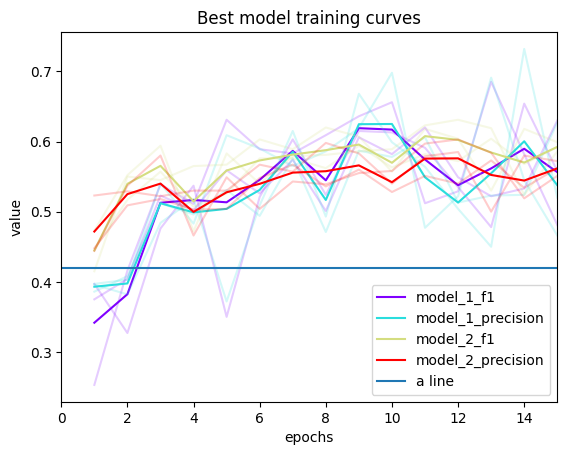

In [32]:
project.plot_episodes(
    best_episodes,
    metrics=METRICS, 
    episode_labels=["model_1", "model_2"], 
    add_hlines=[(0.42, "a line")], # we'll add a random horizontal line here but you can use this parameter to mark important thresholds
    title="Best model training curves"
)

The bold lines here are the means over the two runs of each episode and the transparent lines are the individual runs.

We can also check out more metrics now.

In [33]:
for episode in best_episodes:
    project.evaluate(
        [episode],
        parameters_update={
            "general": {"metric_functions": ["segmental_f1", "mAP", "f1"]},
            "metrics": {
                "f1": {"average": "none"} # you can also update parameters for metrics (check project.list_basic_parameters() for options)
            }
        }
    )

EVALUATION c2f_tcn_best
episode c2f_tcn_best::0
Number of samples:
    validation:
      {-100: 161290, 0: 169, 3: 42341, 4: 27320, 1: 7446, 2: 538}
    training:
      {-100: 649094, 3: 163336, 2: 1990, 4: 92604, 1: 26480, 0: 384}
    test:
      {1: 0, 2: 0, 3: 0, 4: 0, 0: 0}
Setting loaded normalization statistics...
Initializing class weights:
    4.75, 0.069, 0.917, 0.011, 0.02
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported


  0%|          | 0/8 [00:00<?, ?it/s]/home/liza/DLC2Action_minimal/dlc2action/model/c2f_tcn.py:92: UserWarning:

__floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').

100%|██████████| 8/8 [00:13<00:00,  1.63s/it]


f1_0 0.000, f1_1 0.505, f1_2 0.616, f1_3 0.912, f1_4 0.757, mAP 0.119, segmental_f1 0.146


AGGREGATED:
f1_0 0.000, f1_1 0.505, f1_2 0.616, f1_3 0.912, f1_4 0.757, mAP 0.119, segmental_f1 0.146
Inference time: 0:00:13


EVALUATION transformer_best
episode transformer_best::0
Number of samples:
    validation:
      {-100: 73313, 0: 244, 3: 42536, 4: 27320, 1: 7592, 2: 739}
    training:
      {-100: 261607, 3: 164564, 2: 2670, 4: 92860, 1: 26480, 0: 491}
    test:
      {1: 0, 2: 0, 3: 0, 4: 0, 0: 0}
Setting loaded normalization statistics...
Initializing class weights:
    17.46, 0.324, 3.211, 0.052, 0.092
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported


100%|██████████| 38/38 [00:05<00:00,  6.51it/s]


f1_0 0.005, f1_1 0.551, f1_2 0.698, f1_3 0.893, f1_4 0.784, mAP 0.265, segmental_f1 0.221


AGGREGATED:
f1_0 0.005, f1_1 0.551, f1_2 0.698, f1_3 0.893, f1_4 0.784, mAP 0.265, segmental_f1 0.221
Inference time: 0:00:05




There are several ways to summarize the results.

In [34]:
project.get_results_table(best_episodes)

RESULTS:
         c2f_tcn_best precision  c2f_tcn_best f1  transformer_best precision  \
average                0.537579         0.556522                    0.561453   

         transformer_best f1  
average             0.592436  




,c2f_tcn_best precision,c2f_tcn_best f1,transformer_best precision,transformer_best f1
average,0.537579,0.556522,0.561453,0.592436


The `get_summary` method will only show the metrics computed during training while `get_results_table` also pulls up the results of evaluation.

In [35]:
for episode in best_episodes:
    _ = project.get_summary([episode])

SUMMARY ['c2f_tcn_best']
loss: mean 1.049, std 0.031
f1: mean 0.556, std 0.061
precision: mean 0.538, std 0.067


SUMMARY ['transformer_best']
loss: mean 0.016, std 0.002
f1: mean 0.592, std 0.005
precision: mean 0.562, std 0.009




## Using trained models

After your models are trained, there's a few ways you can use them.

If you're still not quite happy with the results, you can train the model for a few more epochs with `project.continue_episode()`.

In [36]:
project.continue_episode(f"{MODEL_NAME1}_best", num_epochs=20, n_seeds=3)

TRAINING c2f_tcn_best::0
Computing input features...


  0%|          | 0/20 [00:00<?, ?it/s]

You can also train another episode with different parameters that loads the weights of your model as an initialization. Note that it will use all three runs as starting points for its own three runs.

In [ ]:
project.run_episode(
    f"{MODEL_NAME1}_best_lr1e-5",
    load_episode=f"{MODEL_NAME1}_best",
    load_search=f"{MODEL_NAME1}_search",
    parameters_update={
        "general": {"model_name": MODEL_NAME1},
        "training": {"lr": 1e-5, "num_epochs": 5}
    },
    force=True,
)

You can also plot such episodes together as one line.

In [ ]:
project.plot_episodes(
    [[f"{MODEL_NAME1}_best", f"{MODEL_NAME1}_best_lr1e-5"], f"{MODEL_NAME2}_best"], 
    episode_labels=["combined_model1", "model2"],
    metrics=METRICS
)

All the episodes you have run are stored in the project memory and you can pull up the history with all the parameters.

In [ ]:
_ = project.list_episodes(
    display_parameters=["general/model_name", "meta/training_time", "meta/time", f"results/{METRICS[0]}"], # choose the parameters to display
    value_filter="training/lr::>1e-5" # filter the entries by any parameter or result
)

The same goes for hyperparameter searches and predictions. This function also returns a `pandas` table you can process yourself.

In [ ]:
searches = project.list_searches(print_results=False)
searches.head()

When you find that you are happy with the results, you can use the model to generate predictions for new data. 

Predictions here are probabilities of each behavior being seen in each frame while suggestions are suggested intervals generated from those probabilities.

Let's generate a prediction with one of our models and look at one of the resulting files. Note that you can use multiple models and average over their predictions.

In [ ]:
project.run_prediction(
    f"{MODEL_NAME1}_best_prediction",
    episode_names=[f"{MODEL_NAME1}_best_lr1e-5"],
    force=True
)

In [ ]:
import pickle
import os


# picking a random file from the prediction folder
prediction_folder = project.prediction_path(f"{MODEL_NAME1}_best_prediction")
prediction_file = os.listdir(prediction_folder)[0]
prediction_file = os.path.join(prediction_folder, prediction_file)

with open(prediction_file, "rb") as f: # open the file
    prediction = pickle.load(f)

for key, value in prediction.items(): # explore the contents
    if key not in ["max_frames", "min_frames", "video_tag", "behaviors"]: # everything else is prediction tensors
        print(f'{key}: {value.shape}')
    
behaviors_order = prediction["behaviors"]

start = 50
end = 70
action = "Unsupported"

index = behaviors_order.index(action)

print(f'The mean probability of {action} between frames {start} and {end} is {prediction["ind0"][index, start: end].mean()}')

In [ ]:
project.remove_saved_features()
project.remove_extra_checkpoints()

## Working with custom annotation data

If you want to work with your own data, first check `Project.print_data_types()` and `Project.print_annotation_types()` to check if we already have the format that you need.

If we don't, you can choose either of them to transform your data to but the easiest is probably `DeepLabCut` track or tracklet for the pose estimation data and our custom `"dlc"` format for annotation.

Let's talk about the latter in more detail.

It assumes every annotation file to be a pickled nested dictionary where first-level keys are individual names, second-level keys are behavior names and values are lists of intervals. Here is an example.
```
{
    "ind0": {
        "running": [[20, 30], [40, 50]]
    },
    "ind1": {
        "eating": [[10, 56]]
    }
}
```

Here `"ind0"` is running in frames 20 to 30 and 40 to 50 while `"ind1"` is eating in frames 10 to 56.

In case your dataset contains interactive actions, connect the individual names with a plus in alphabetical order (e.g. `"ind0+ind1"`). At the moment, we can only support two scenarios: either all actions are interactive or all are individual. In case they are interactive, update the parameters with `project.update_parameters({"general": {"interactive": True}})` before running experiments.

As an exercise, let's generate a file in this format from one of the CSV files we've been working with.

In [ ]:
import os
import pandas as pd
from collections import defaultdict
import pickle
import numpy as np

filename = [x for x in os.listdir(LABELS_PATH) if x.endswith(".csv")][0] # load a random .csv file
filepath = os.path.join(LABELS_PATH, filename)

data = pd.read_csv(filepath)

In [ ]:
data.head()

Behaviors here are not interactive. We don't have a name for the animal so we will call it `"ind0"` (that is the default name for single animal DLC track files as well in DLC2Action but you can set something else at `"data/default_agent_name"`, just make sure that the names are consistent between annotation and input data). The annotations are encoded as start and end times in seconds. If we download the original videos and check the frame rate we can see that it's 25 fps.

Furthermore, the StartEnd behavior doesn't appear to be meaningful for us.

Given this information, let's transform this into the DLC format.

In [ ]:
FPS = 25
OMITTED_BEHAVIORS = ["StartEnd"]

for filename in [x for x in os.listdir(LABELS_PATH) if x.endswith(".csv")]:
    if filename == "AllLabDataOFT_final.csv": # this is the raw data with all videos together
        continue
    filepath = os.path.join(LABELS_PATH, filename)
    data = pd.read_csv(filepath)
    dlc_dict = {"ind0": defaultdict(lambda: [])} # this is just a dictionary that returns an empty list when we try to use a key that doesn't exist
    for _, row in data.iterrows():
        behavior = row["type"]
        if behavior in OMITTED_BEHAVIORS: # ignore extra behaviors
            continue
        if any([np.isnan(x) for x in [row["from"], row["to"]]]): # skip nans
            continue
        start = int(row["from"] * FPS)
        end = int(row["to"] * FPS)
        dlc_dict["ind0"][behavior].append([start, end])
    new_name = filepath.split(".")[0] + "_dlc.pickle" # the filenames need to start with the video name
    dlc_dict["ind0"] = dict(dlc_dict["ind0"]) # we need to convert the defaultdict back to a standard dictionary before saving
    with open(new_name, "wb") as f: # save the annotation file
        pickle.dump(dlc_dict, f)

Let's check that we did everything right. We will create a new project with the new data type and run a small experiment.

In [ ]:
# Project.remove_project("oft_dlc", projects_path=PROJECTS_PATH)

project = Project(
    "oft_dlc",
    data_path=DATA_PATH,
    annotation_path=LABELS_PATH,
    data_type="dlc_track",
    annotation_type="dlc",
    projects_path=PROJECTS_PATH
)

In [ ]:
project.update_parameters(
    {
        "data": {
            "data_suffix": "DeepCut_resnet50_Blockcourse1May9shuffle1_1030000.csv", # set; the data files should have the format of {video_id}{data_suffix}, e.g. video1_suffix.pickle, where video1 is the video is and _suffix.pickle is the suffix
            "canvas_shape": [928, 576], # list; the size of the canvas where the pose was defined
            "annotation_suffix": "_dlc.pickle", # str | set, optional the suffix or the set of suffices such that the annotation files are named {video_id}{annotation_suffix}, e.g, video1_suffix.pickle where video1 is the video id and _suffix.pickle is the suffix
            "fps": 25 # int; fps (assuming the annotations are given in seconds, otherwise set any value)
        },
        "general": {
            "exclusive": True, # bool; if true, single-label classification is used; otherwise multi-label
        },
    }
)

In [ ]:
project.run_episode("test", force=True, parameters_update={"training": {"num_epochs": 1}})

## Annotation

You can also use `DLC2Action` to generate new annotation files. Install our interface following those instructions and try running it with any video you like.

To install:
```
git clone https://github.com/amathislab/dlc2action_annotation
cd dlc2action_annotation
conda env create -f AnnotationGUI.yaml
```

To start, go to the `dlc2action_annotation` folder and run `python annotator.py`.

Check out the [user guide](https://github.com/amathislab/dlc2action_annotation) for instructions.